# Figure 6 for the paper manuscript

In [1]:
# import area

import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi 
import pandexo.engine.justplotit as jpi
from pandexo.engine.bintools import bin_wave_to_R
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import astropy
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, ScalarFormatter, NullFormatter
from scipy.ndimage import gaussian_filter1d as gauss_conv
import pickle as pk
import numpy as np
import pandas as pd
import scipy.constants as sc
from spectres import spectres 
import copy
import pysynphot as psyn
from os import listdir
import matplotlib

In [1]:
# non-pandexo imports

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import astropy
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, ScalarFormatter, NullFormatter
from scipy.ndimage import gaussian_filter1d as gauss_conv
import pickle as pk
import numpy as np
import pandas as pd
import scipy.constants as sc
from spectres import spectres 
import copy
import pysynphot as psyn
from os import listdir
import matplotlib

In [8]:
# local version of pandexo's bin_wave_to_R function

def bin_wave_to_R(w, R):
	"""Creates new wavelength axis at specified resolution

	Parameters
	----------
	w : list of float or numpy array of float
	    Wavelength axis to be rebinned 
	R : float or int 
	    Resolution to bin axis to 

	Returns
	-------
	list of float
	    New wavelength axis at specified resolution

	Examples
	--------

	>>> newwave = bin_wave_to_R(np.linspace(1,2,1000), 10)
	>>> print((len(newwave)))
	11
	"""
	wave = []
	tracker = min(w)
	i = 1 
	ind= 0
	firsttime = True
	while(tracker<max(w)):
	    if i <len(w)-1:
	        dlambda = w[i]-w[ind]
	        newR = w[i]/dlambda
	        if (newR < R) & (firsttime):
	            tracker = w[ind]
	            wave += [tracker]
	            ind += 1
	            i += 1 
	            firsttime = True
	        elif newR < R:
	            tracker = w[ind]+dlambda/2.0
	            wave +=[tracker]
	            ind = (np.abs(w-tracker)).argmin()
	            i = ind+1
	            firsttime = True
	        else:
	            firsttime = False            
	            i+=1    
	    else:
	        tracker = max(w)
	        wave += [tracker]
	return wave

### Define global variables and helper functions

We will use the dayside temperature of LHS-3844b as the constant temperature value as it provides a match to the Spitzer data point

In [2]:
# planetary parameters

R_p = 0.116*7.1492*10**7   # planetary radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al.
D_p = 7.039*R_star
T_star = 3036    # stellar temperature in K
T_dayside = 1040    # dayside brightness temperature in K (from Kreidberg et al.)

#A_basalt = 0
#T_eq = T_star*np.sqrt(R_star/(2*D_p))*(1 - A_basalt)**(0.25)

# stellar spectrum

data = np.loadtxt('Resources/LHS3844_nextgensolar_spectrum.txt', skiprows=7)
stellar_wav_n = data[:,0]
stellar_flux_n = data[:,1]

# convert wavelength axis to m

stellar_wav_n = stellar_wav_n*10**-10

# convert from erg/cm2/s/A to jy (10^-23 ergs/cm2/s/Hz)

c = 3.0e+8
stellar_flux_n = 10**23*stellar_flux_n*10**10*(stellar_wav_n)**2/c

# slice the arrays between 1 and 25 microns

stellar_wav = stellar_wav_n
stellar_flux = stellar_flux_n

ind = np.where((stellar_wav > 1.0*10**-6) & (stellar_wav < 25.0*10**-6))
stellar_wav = stellar_wav[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
stellar_flux = stellar_flux[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
stellar_flux = stellar_flux*c/(stellar_wav)**2

# convert from flux density to spectral radiance

stellar_radiance = stellar_flux/np.pi

In [2]:
# inputs for phoenix stellar model

# stellar properties

star_dict = {}
star_dict['type'] = 'phoenix'        #phoenix or user (if you have your own)
star_dict['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
star_dict['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
star_dict['temp'] = 3036            #in K
#star_dict['temp'] = 3500             # minimum limit for pysynphot's ck04models grid
star_dict['metal'] = 0.0             # as log Fe/H (don't know this value)
#star_dict['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
star_dict['logg'] = 5.00             # maximum limit for pysynphot's ck04models grid

# planetary parameters

R_p = 0.116*7.1492*10**7   # planetary radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al.
D_p = 7.039*R_star
T_star = 3036    # stellar temperature in K
T_dayside = 1040    # dayside brightness temperature in K (from Kreidberg et al.)

# Load models

sp = psyn.Icat("phoenix", star_dict['temp'], star_dict['metal'], star_dict['logg'])
sp.convert("m")
sp.convert("jy")
stellar_wav_p = sp.wave
stellar_flux_p = sp.flux

# slice the arrays between 1 and 30 microns

stellar_wav = stellar_wav_p
stellar_flux = stellar_flux_p

ind = np.where((stellar_wav > 1.0*10**-6) & (stellar_wav < 30.0*10**-6))
stellar_wav = stellar_wav[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
stellar_flux = stellar_flux[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
stellar_flux = stellar_flux*c/(stellar_wav)**2

# convert from flux density to spectral radiance

stellar_radiance = stellar_flux/np.pi

In [3]:
# define a function to calculate F_p/F_* at a given wavelength

def bb(wav,T):
    pi = np.pi
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23

    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity


def fp_over_fstar(wav_array,R_p, D_p, eps_array, spec_star, T_00, R_star, constant_T=False):
    
    theta_array, dtheta = np.linspace(-np.pi/2, np.pi/2,num=100, retstep=True)
    phi_array, dphi = np.linspace(-np.pi/2, np.pi/2,num=100,retstep=True)
    
    theta_mesh, phi_mesh = np.meshgrid(theta_array, phi_array)
    
    spec = np.full(wav_array.size, np.nan)
    
    for i in range(wav_array.size):
        wav = wav_array[i]
        eps = eps_array[i]
        if constant_T:
            T_mesh = T_00*np.ones(theta_mesh.shape)
        else:
            T_mesh = T_00*(np.cos(theta_mesh)*np.cos(phi_mesh))**0.25
        B_mesh = bb(wav,T_mesh)
        angles_mesh = np.cos(theta_mesh)**2*np.cos(phi_mesh)
        integral = np.sum(eps*B_mesh*angles_mesh*dtheta*dphi)
            
        spec[i] = (R_p/D_p)**2*(1 - eps + integral/(np.pi*spec_star[i]*(R_star/D_p)**2))
        
    if np.sum(np.isnan(spec)) == True:
        raise ValueError('spec has one or more nan values in it')
    else:
        return spec

### Emily: *Figure 6a. Run each of the 15 samples with the same simulation parameters: transits = 5, R = 50. I will use a subset of these for Figure 6a. We had talked about these being good values to use for this purpose, but let me know if you think different # transits or R would be better.*

In [9]:
# load emissivity files

#(_, _, filenames) = walk('data_Emily/spectra_csv/csv - unaltered spectra/').next()

path = 'data_Emily/spectra_csv/csv - unaltered spectra/'
emissivity_files = listdir(path)

# for each emissivity file, generate models and write them to files

list_models = []

for emissivity_file in emissivity_files:
    # load emissivity data
    eps = np.loadtxt(path + emissivity_file, delimiter=',')
    wav_eps, eps  = eps[:,0][::-1], eps[:,1][::-1]

    # match the stellar wavelength axis to the emissivity wavelength axis
    stellar_radiance_mod = spectres(wav_eps, stellar_wav*10**6, stellar_radiance)

    wav_eps = wav_eps[~np.isnan(stellar_radiance_mod)]
    eps = eps[~np.isnan(stellar_radiance_mod)]
    stellar_radiance_mod = stellar_radiance_mod[~np.isnan(stellar_radiance_mod)]

    # calculate model

    model = fp_over_fstar(wav_eps*10**-6, R_p, D_p, eps, stellar_radiance_mod, T_dayside, R_star, constant_T=True)

    list_models.append(model)

    # write output to a file

    file_prefix = 'simulation_outputs/paper/figure_6/figure_6a'
    np.savetxt(file_prefix + emissivity_file[:4] + '_model.txt', np.array([wav_eps, model]).T, delimiter='\t', fmt='%s')



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

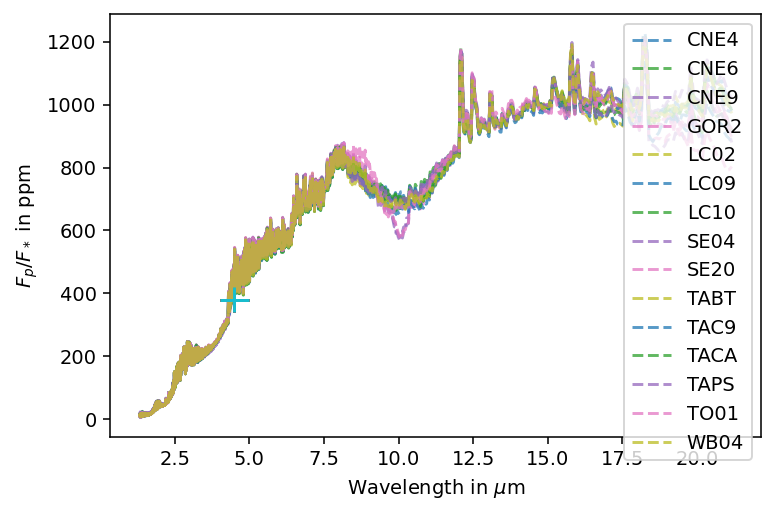

In [8]:
# plot all the models

plt.figure()

for i,model in enumerate(list_models):
    plt.plot(wav_eps, model*10**6, ls='--', alpha=0.75, label=emissivity_files[i][:4])
    plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40)
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()

In [6]:
#### models created using phoenix

# load emissivity files

#(_, _, filenames) = walk('data_Emily/spectra_csv/csv - unaltered spectra/').next()

path = 'data_Emily/spectra_csv/csv - unaltered spectra/'
emissivity_files = listdir(path)

# for each emissivity file, generate models and write them to files

list_models = []

for emissivity_file in emissivity_files:
    # load emissivity data
    eps = np.loadtxt(path + emissivity_file, delimiter=',')
    wav_eps, eps  = eps[:,0][::-1], eps[:,1][::-1]

    # match the stellar wavelength axis to the emissivity wavelength axis
    stellar_radiance_mod = spectres(wav_eps, stellar_wav*10**6, stellar_radiance)

    wav_eps = wav_eps[~np.isnan(stellar_radiance_mod)]
    eps = eps[~np.isnan(stellar_radiance_mod)]
    stellar_radiance_mod = stellar_radiance_mod[~np.isnan(stellar_radiance_mod)]

    # calculate model

    model = fp_over_fstar(wav_eps*10**-6, R_p, D_p, eps, stellar_radiance_mod, T_dayside, R_star, constant_T=True)

    list_models.append(model)

    # write output to a file

    #file_prefix = 'simulation_outputs/paper/figure_6/figure_6a/phoenix/'
    #np.savetxt(file_prefix + emissivity_file[:4] + '_model.txt', np.array([wav_eps, model]).T, delimiter='\t', fmt='%s')

# also calculate a blackbody emission spectrum

eps_bb = np.ones(eps.size)
wav_eps_bb = np.copy(wav_eps)

# match the stellar wavelength axis to the emissivity wavelength axis
stellar_radiance_mod = spectres(wav_eps_bb, stellar_wav*10**6, stellar_radiance)

wav_eps_bb = wav_eps_bb[~np.isnan(stellar_radiance_mod)]
eps_bb = eps_bb[~np.isnan(stellar_radiance_mod)]
stellar_radiance_mod = stellar_radiance_mod[~np.isnan(stellar_radiance_mod)]

# calculate model

model_bb = fp_over_fstar(wav_eps_bb*10**-6, R_p, D_p, eps_bb, stellar_radiance_mod, T_dayside, R_star, constant_T=True)

file_prefix = 'simulation_outputs/paper/figure_6/figure_6a/phoenix/'
np.savetxt(file_prefix + 'blackbody' + '_model.txt', np.array([wav_eps_bb, model_bb]).T, delimiter='\t', fmt='%s')

In [9]:
# also make R=100 and R=200 versions of the blackbody model

wav_eps_bb_r100 = bin_wave_to_R(wav_eps_bb, 100/2)
wav_eps_bb_r100 = np.array(wav_eps_bb_r100)

model_bb_r100 = spectres(wav_eps_bb_r100, wav_eps_bb, model_bb)
wav_model_bb_r100 = np.copy(wav_eps_bb_r100)

np.savetxt(file_prefix + 'blackbody' + '_model_R100.txt', np.array([wav_model_bb_r100, model_bb_r100]).T, delimiter='\t', fmt='%s')

wav_eps_bb_r200 = bin_wave_to_R(wav_eps_bb, 200/2)
wav_eps_bb_r200 = np.array(wav_eps_bb_r200)

model_bb_r200 = spectres(wav_eps_bb_r200, wav_eps_bb, model_bb)
wav_model_bb_r200 = np.copy(wav_eps_bb_r200)

np.savetxt(file_prefix + 'blackbody' + '_model_R200.txt', np.array([wav_model_bb_r200, model_bb_r200]).T, delimiter='\t', fmt='%s')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



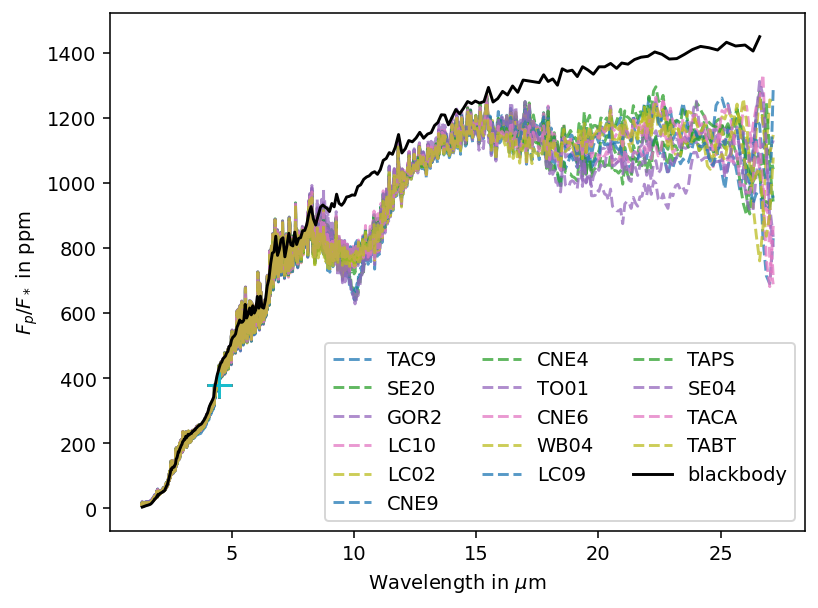

In [10]:
# plot all the models

plt.figure()

for i,model in enumerate(list_models):
    plt.plot(wav_eps, model*10**6, ls='--', alpha=0.75, label=emissivity_files[i][:4])
    plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40)

plt.plot(wav_eps_bb_r100, model_bb_r100*10**6, color='black', label='blackbody')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend(loc='lower right', ncol=3)

In [14]:
# bin the models to R=100 and save those files as well

list_models_r100 = []

for i, model in enumerate(list_models):
    # create new wavelength axis at R=100

    wav_eps_r100 = bin_wave_to_R(wav_eps, 100/2)
    wav_eps_r100 = np.array(wav_eps_r100)

    model_r100 = spectres(wav_eps_r100, wav_eps, list_models[i])
    wav_model_r100 = np.copy(wav_eps_r100)
    list_models_r100.append(model_r100)

    # write output to a file

    file_prefix = 'simulation_outputs/paper/figure_6/figure_6a/phoenix/'
    np.savetxt(file_prefix + emissivity_files[i][:4] + '_model_R100.txt', 
                np.array([wav_model_r100, model_r100]).T, delimiter='\t', fmt='%s')



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

In [2]:
file_prefix = 'simulation_outputs/paper/figure_6/figure_6a/phoenix/'
for file in listdir(file_prefix):
    if file.endswith("_model.txt"):
        print(file)

CNE4_model.txt
CNE6_model.txt
CNE9_model.txt
GOR2_model.txt
LC02_model.txt
LC09_model.txt
LC10_model.txt
SE04_model.txt
SE20_model.txt
TABT_model.txt
TAC9_model.txt
TACA_model.txt
TAPS_model.txt
TO01_model.txt
WB04_model.txt


In [6]:
# bin the models to R=200 and save those files as well

list_models_r200 = []

# load high-res models

list_models = []
file_name_list = []

file_prefix = 'simulation_outputs/paper/figure_6/figure_6a/phoenix/'
for file in listdir(file_prefix):
    if file.endswith("_model.txt"):
        model_file = np.loadtxt(file_prefix + file, delimiter='\t')
        wav_model, model = model_file[:,0], model_file[:,1]
        list_models.append(model)
        file_name_list.append(file)

for i, model in enumerate(list_models):

    # create new wavelength axis at R=200

    wav_eps_r200 = bin_wave_to_R(wav_model, 200/2)
    wav_eps_r200 = np.array(wav_eps_r200)

    model_r200 = spectres(wav_eps_r200, wav_model, list_models[i])
    wav_model_r200 = np.copy(wav_eps_r200)
    list_models_r200.append(model_r200)

    # write output to a file

    file_prefix = 'simulation_outputs/paper/figure_6/figure_6a/phoenix/'
    np.savetxt(file_prefix + file_name_list[i][:4] + '_model_R200.txt', 
                np.array([wav_model_r200, model_r200]).T, delimiter='\t', fmt='%s')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

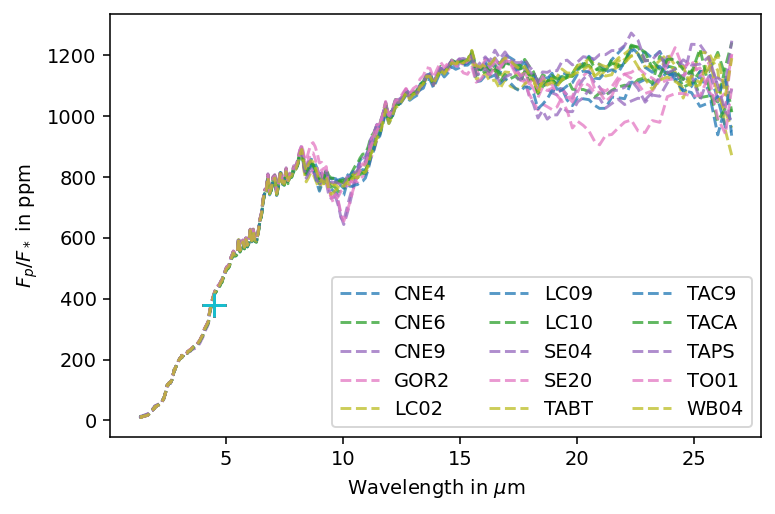

In [15]:
# plot all the models at R=100

plt.figure()

for i,model in enumerate(list_models_r100):
    plt.plot(wav_eps_r100, model*10**6, ls='--', alpha=0.75, label=emissivity_files[i][:4])
    plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40)
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend(loc='lower right', ncol=3)

Create a stellar file to be used by pandexo

In [7]:
data = np.loadtxt('Resources/LHS3844_nextgensolar_spectrum.txt', skiprows=7)
stellar_wav_n = data[:,0]
stellar_flux_n = data[:,1]

# convert wavelength axis to microns

stellar_wav_n = stellar_wav_n*10**-4

# convert from erg/cm2/s/A to jy (10^-23 ergs/cm2/s/Hz)

c = 3.0e+8
stellar_flux_n = 10**23*stellar_flux_n*10**10*(stellar_wav_n)**2/c

#slice the arrays between 1 and 25 microns

ind = np.where((stellar_wav_n > 1.0) & (stellar_wav_n < 25.0))
wav_stellar = stellar_wav_n[ind]
spec_stellar = stellar_flux_n[ind]

# Write spectrum
f = open('./Resources/'  + 'LHS3844_stellar.dat','w')
    
for i in range(wav_stellar.size):
    f.write('%.8e %.8e \n' %(wav_stellar[i], spec_stellar[i]))

f.close()

In [5]:
# for each model, simulate JWST observations for 5 transits and at R = 50

file_prefix = 'simulation_outputs/paper/figure_6/figure_6a/'

path = 'data_Emily/spectra_csv/csv - unaltered spectra/'
emissivity_files = listdir(path)

for i, emissivity_file in enumerate(emissivity_files):

    # set up the run

    exo_dict = jdi.load_exo_dict()

    # exoplanet observation inputs

    exo_dict['observation']['sat_level'] = 100    #saturation level in percent of full well
    exo_dict['observation']['sat_unit'] = '%'
    exo_dict['observation']['noccultations'] = 1 #number of transits
    exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                                #without having to redo the calcualtion
    exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                        #'frac' : fraction of time in transit versus out = in/out
                                                        #'total' : total observing time (seconds)
    exo_dict['observation']['baseline'] = 4*0.5212*60.0*60.0 #in accordance with what was specified above (total observing time)

    exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                                #to a wavelength dependent noise floor solution (units are ppm)

    # exoplanet host star inputs

    exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
    exo_dict['star']['starpath'] = './Resources/LHS3844_stellar.dat'
    exo_dict['star']['w_unit'] = 'um'                      
    exo_dict['star']['f_unit'] = 'Jy'      
    exo_dict['star']['mag'] = 9.1            #magnitude of the system (obtained from SIMBAD)
    exo_dict['star']['ref_wave'] = 2.22         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)

    '''
    exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
    exo_dict['star']['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
    exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
    exo_dict['star']['temp'] = 3036             #in K
    exo_dict['star']['metal'] = 0.0             # as log Fe/H (don't know this value)
    exo_dict['star']['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
    '''

    # exoplanet planetary inputs
    exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
    exo_dict['planet']['f_unit'] = 'fp/f*'                 # Other options are 'fp/f*'
    exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
    exo_dict['planet']['td_unit'] = 's'

    # basalt
    
    exo_dict['planet']['exopath'] = file_prefix + emissivity_file[:4] + '_model.txt'

    # load instrument

    inst_dict = jdi.load_mode_dict('MIRI LRS')

    # run simulation

    result = jdi.run_pandexo(exo_dict, inst_dict, output_path = file_prefix, output_file=emissivity_file[:4] + '.p')
    
    R = 50

    # load outputs from run

    out = pk.load(open(file_prefix + emissivity_file[:4] + '.p','rb'))
    x,y,y_err = jpi.jwst_1d_spec(out, R=R/2, num_tran=5, model=True, plot=False)
    x,y,y_err = x[0], y[0], y_err[0]
    #x_err = [x[i+1] - x[i] for i in range(x.size-1)]
    #x_err.insert(0,x[1] - x[0])

    # write the wavelength, wav_error, flux and flux_error in a file

    np.savetxt(file_prefix + emissivity_file[:4] + '_jwst.txt', np.array([x, y, y_err]).T, delimiter='\t', fmt='%s')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation


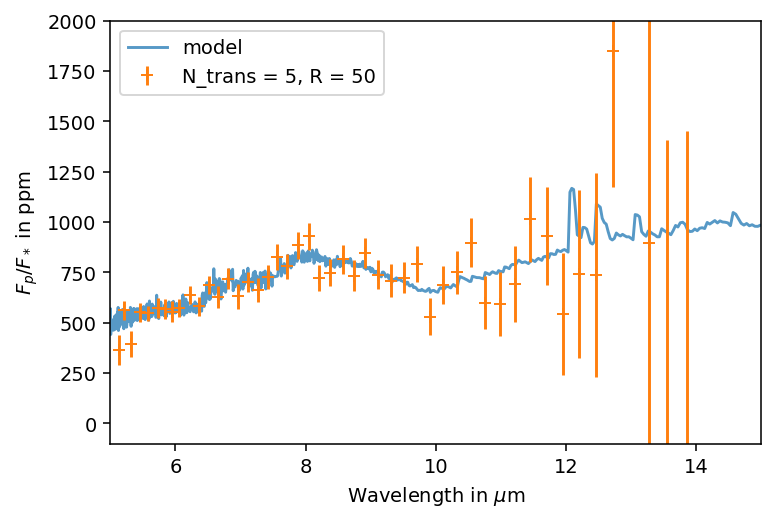

In [7]:
plt.figure()
file_prefix = 'simulation_outputs/paper/figure_6/figure_6a/'
data  = np.loadtxt(file_prefix + 'CNE4_model.txt')
wav_model, spec_model = data[:,0], data[:,1]
data = np.loadtxt(file_prefix + 'CNE4_jwst.txt')
x, y, y_err = data[:,0], data[:,1], data[:,2]
plt.plot(wav_model, spec_model*10**6, alpha=0.75, label='model')
plt.errorbar(x,10**6*y, yerr=10**6*y_err, ls='', fmt='+', label='N_trans = 5, R = 50')
#plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40,  label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.xlim((5,15))
plt.ylim((-100,2000))

plt.legend()

### Emily: *Figure 6b. Run samples LC10, SE20, and TO01 using R = 50 and transits = 1, 3, 5 [done above], 10, 20 (or other values you think are more helpful. I definitely want 1 and 10 included; if it's not reasonable that 20 transits would ever be observed, we can skip or replace that, for example).*

In [8]:
files = ['LC10', 'SE20', 'TO01']
num_transits_list = [1,3,5,10,20]

file_prefix = 'simulation_outputs/paper/figure_6/figure_6b/'

for file in files:
        
    # set up the run

    exo_dict = jdi.load_exo_dict()

    # exoplanet observation inputs

    exo_dict['observation']['sat_level'] = 100    #saturation level in percent of full well
    exo_dict['observation']['sat_unit'] = '%'
    exo_dict['observation']['noccultations'] = 1 #number of transits
    exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                                    #without having to redo the calcualtion
    exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                            #'frac' : fraction of time in transit versus out = in/out
                                                            #'total' : total observing time (seconds)
    exo_dict['observation']['baseline'] = 4*0.5212*60.0*60.0 #in accordance with what was specified above (total observing time)

    exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                                    #to a wavelength dependent noise floor solution (units are ppm)

    # exoplanet host star inputs

    exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
    exo_dict['star']['starpath'] = './Resources/LHS3844_stellar.dat'
    exo_dict['star']['w_unit'] = 'um'                      
    exo_dict['star']['f_unit'] = 'Jy'      
    exo_dict['star']['mag'] = 9.1            #magnitude of the system (obtained from SIMBAD)
    exo_dict['star']['ref_wave'] = 2.22         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)

    '''
    exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
    exo_dict['star']['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
    exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
    exo_dict['star']['temp'] = 3036             #in K
    exo_dict['star']['metal'] = 0.0             # as log Fe/H (don't know this value)
    exo_dict['star']['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
    '''

    # exoplanet planetary inputs
    exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
    exo_dict['planet']['f_unit'] = 'fp/f*'                 # Other options are 'fp/f*'
    exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
    exo_dict['planet']['td_unit'] = 's'

    # basalt
    
    exo_dict['planet']['exopath'] = file_prefix + file + '_model.txt'

    # load instrument

    inst_dict = jdi.load_mode_dict('MIRI LRS')

    # run simulation

    result = jdi.run_pandexo(exo_dict, inst_dict, output_path = file_prefix, output_file=file + '.p')
    
    R = 50
    
    for num_transits in num_transits_list:
        
        # load outputs from run

        out = pk.load(open(file_prefix + file + '.p','rb'))
        x,y,y_err = jpi.jwst_1d_spec(out, R=R/2, num_tran=num_transits, model=True, plot=False)
        x,y,y_err = x[0], y[0], y_err[0]
        #x_err = [x[i+1] - x[i] for i in range(x.size-1)]
        #x_err.insert(0,x[1] - x[0])

        # write the wavelength, wav_error, flux and flux_error in a file

        np.savetxt(file_prefix + file + '_ntrans_' + str(num_transits) + '_jwst.txt', np.array([x, y, y_err]).T, delimiter='\t', fmt='%s')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


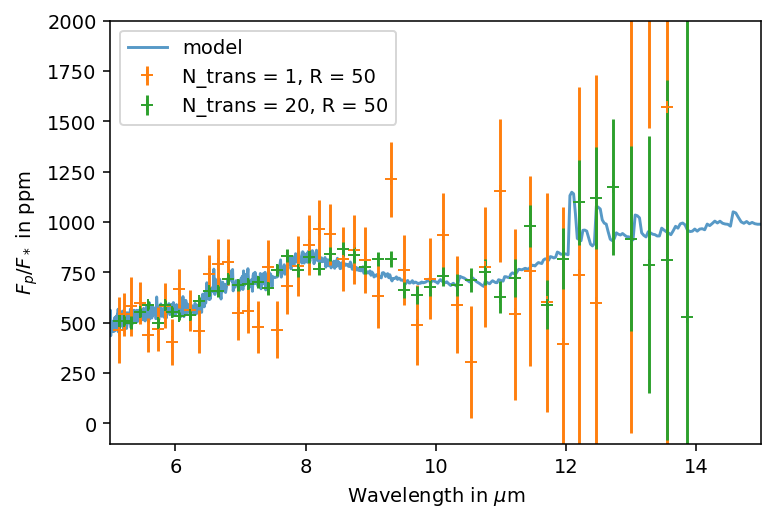

In [9]:
plt.figure()
file_prefix = 'simulation_outputs/paper/figure_6/figure_6b/'
data  = np.loadtxt(file_prefix + 'LC10_model.txt')
wav_model, spec_model = data[:,0], data[:,1]
plt.plot(wav_model, spec_model*10**6, alpha=0.75, label='model')

for num_transits in [1,20]:

    data = np.loadtxt(file_prefix + file + '_ntrans_' + str(num_transits) + '_jwst.txt')
    x, y, y_err = data[:,0], data[:,1], data[:,2]
    plt.errorbar(x,10**6*y, yerr=10**6*y_err, ls='', fmt='+', label='N_trans = %d, R = 50'%num_transits)
#plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40,  label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.xlim((5,15))
plt.ylim((-100,2000))

plt.legend()

### Emily: *Figure 6c. Run samples LC10, SE20, and TO01 using transits = 5 and R = 10, 30, 50 [done above], 100, 200 (or, again, other R values you think are more likely to be used, if any)*

In [10]:
files = ['LC10', 'SE20', 'TO01']
R_list = [10,30,50,100,200]
#R_list = [20]

file_prefix = 'simulation_outputs/paper/figure_6/figure_6c/'

for file in files:
        
    # set up the run

    exo_dict = jdi.load_exo_dict()

    # exoplanet observation inputs

    exo_dict['observation']['sat_level'] = 100    #saturation level in percent of full well
    exo_dict['observation']['sat_unit'] = '%'
    exo_dict['observation']['noccultations'] = 1 #number of transits
    exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                                    #without having to redo the calcualtion
    exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                            #'frac' : fraction of time in transit versus out = in/out
                                                            #'total' : total observing time (seconds)
    exo_dict['observation']['baseline'] = 4*0.5212*60.0*60.0 #in accordance with what was specified above (total observing time)

    exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                                    #to a wavelength dependent noise floor solution (units are ppm)

    # exoplanet host star inputs

    exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
    exo_dict['star']['starpath'] = './Resources/LHS3844_stellar.dat'
    exo_dict['star']['w_unit'] = 'um'                      
    exo_dict['star']['f_unit'] = 'Jy'      
    exo_dict['star']['mag'] = 9.1            #magnitude of the system (obtained from SIMBAD)
    exo_dict['star']['ref_wave'] = 2.22         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)

    '''
    exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
    exo_dict['star']['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
    exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
    exo_dict['star']['temp'] = 3036             #in K
    exo_dict['star']['metal'] = 0.0             # as log Fe/H (don't know this value)
    exo_dict['star']['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
    '''

    # exoplanet planetary inputs
    exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
    exo_dict['planet']['f_unit'] = 'fp/f*'                 # Other options are 'fp/f*'
    exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
    exo_dict['planet']['td_unit'] = 's'

    # basalt
    
    exo_dict['planet']['exopath'] = file_prefix + file + '_model.txt'

    # load instrument

    inst_dict = jdi.load_mode_dict('MIRI LRS')

    # run simulation

    result = jdi.run_pandexo(exo_dict, inst_dict, output_path = file_prefix, output_file=file + '.p')
    
    num_transits = 5
    
    for R in R_list:
        
        # load outputs from run

        out = pk.load(open(file_prefix + file + '.p','rb'))
        x,y,y_err = jpi.jwst_1d_spec(out, R=R/2, num_tran=num_transits, model=True, plot=False)
        x,y,y_err = x[0], y[0], y_err[0]
        #x_err = [x[i+1] - x[i] for i in range(x.size-1)]
        #x_err.insert(0,x[1] - x[0])

        # write the wavelength, wav_error, flux and flux_error in a file

        np.savetxt(file_prefix + file + '_R_' + str(R) + '_jwst.txt', np.array([x, y, y_err]).T, delimiter='\t', fmt='%s')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


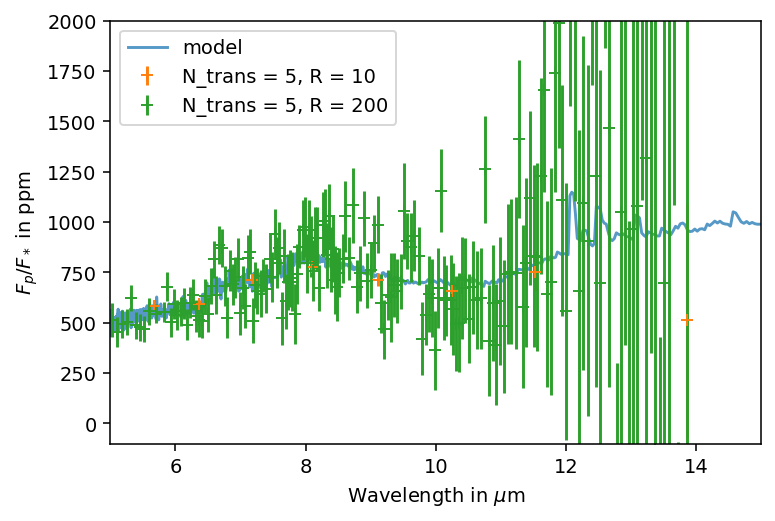

In [11]:
plt.figure()
file_prefix = 'simulation_outputs/paper/figure_6/figure_6c/'
data  = np.loadtxt(file_prefix + 'LC10_model.txt')
wav_model, spec_model = data[:,0], data[:,1]
plt.plot(wav_model, spec_model*10**6, alpha=0.75, label='model')

for R in [10,200]:

    data = np.loadtxt(file_prefix + file + '_R_' + str(R) + '_jwst.txt')
    x, y, y_err = data[:,0], data[:,1], data[:,2]
    plt.errorbar(x,10**6*y, yerr=10**6*y_err, ls='', fmt='+', label='N_trans = 5, R = %d'%R)
#plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40,  label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.xlim((5,15))
plt.ylim((-100,2000))

plt.legend()

Run simulations for R=20

In [3]:
files = ['LC10', 'SE20', 'TO01']
#R_list = [10,30,50,100,200]
R_list = [20]

file_prefix = 'simulation_outputs/paper/figure_6/figure_6c/'

for file in files:
    for R in R_list:
        num_transits=5
        # load outputs from run

        out = pk.load(open(file_prefix + file + '.p','rb'))
        x,y,y_err = jpi.jwst_1d_spec(out, R=R/2, num_tran=num_transits, model=True, plot=False)
        x,y,y_err = x[0], y[0], y_err[0]
        #x_err = [x[i+1] - x[i] for i in range(x.size-1)]
        #x_err.insert(0,x[1] - x[0])

        # write the wavelength, wav_error, flux and flux_error in a file

        np.savetxt(file_prefix + file + '_R_' + str(R) + '_jwst.txt', np.array([x, y, y_err]).T, delimiter='\t', fmt='%s')